 ## Packages

In [9]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import sys

In [10]:
print(f"Python version -> {sys.version}")  # 3.12.3
print(f"torch version -> {torch.__version__}")  # 2.8.0+cu128

Python version -> 3.12.3 (main, Aug 14 2025, 17:47:21) [GCC 13.3.0]
torch version -> 2.8.0+cu128


 ## Generate a random walk

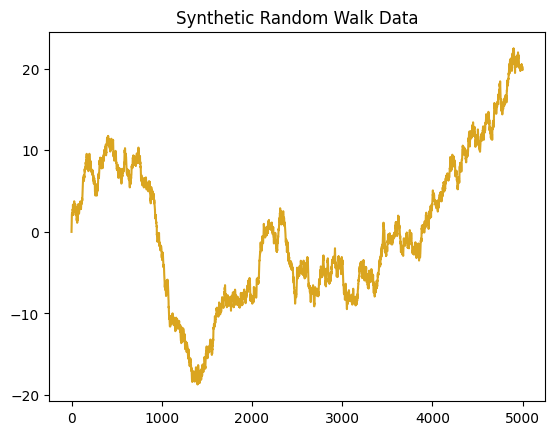

In [11]:
def random_walk(steps, scale=1):
    w = np.zeros(steps)
    for x in range(1, steps):
        w[x] = w[x - 1] + scale * np.random.normal()
    return w


time_steps = 5000
data = pd.DataFrame(
    {
        "x": range(time_steps),
        "y": np.arange(time_steps) ** (1 / 2) + random_walk(time_steps),
    }
)
data = data.assign(z=np.log(data.x + 1) + 0.3 * data.y)
data_mat = np.array(data)

plt.plot(data_mat[:, 0], data_mat[:, 2], c="goldenrod")
plt.title("Synthetic Random Walk Data")
plt.show()

$$
\begin{align}
x_t &= t \\
y_t &= \sqrt{t} + W_t \\
z_t &= \log(t + 1) + 0.3 y_t
\end{align}
$$

 ## Prepare Sliding Window Data

In [12]:
samples = []
target = []
length = 50  # sequence length
test_size = 1000

for i in range(time_steps - length):
    sample = data_mat[i : i + length, :2]
    outcome = data_mat[i + length, 2]
    samples.append(sample)
    target.append(outcome)

# Convert to arrays
samples = np.array(samples)
target = np.array(target)

# Train/test split
x_train = samples[:-test_size]
x_test = samples[-test_size:]
y_train = target[:-test_size]
y_test = target[-test_size:]

print("x_train:", x_train.shape)
print("x_test :", x_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)

x_train: (3950, 50, 2)
x_test : (1000, 50, 2)
y_train: (3950,)
y_test : (1000,)


 ## Convert to PyTorch tensors

In [13]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=25, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=25, shuffle=False)

 ## Define RNN Model

In [14]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, dense1, dense2, dense3):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True,
            nonlinearity="relu",
        )
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(hidden_size, dense1)
        self.fc2 = nn.Linear(dense1, dense2)
        self.fc3 = nn.Linear(dense2, dense3)
        self.out = nn.Linear(dense3, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # take the last hidden state
        out = self.dropout(self.relu(self.fc1(out)))
        out = self.dropout(self.relu(self.fc2(out)))
        out = self.dropout(self.relu(self.fc3(out)))
        out = self.out(out)
        return out


input_size = 2
hidden_size = 128
model = RNNModel(input_size, hidden_size, 64, 16, 16)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)

RNNModel(
  (rnn): RNN(2, 128, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


 ## Compile

In [15]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

 ## Train the Model (with early stopping)

In [16]:
epochs = 50
patience = 7
best_val_loss = np.inf
patience_counter = 0

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_val, y_val in test_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(
        f"Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}"
    )

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

# Load best model
model.load_state_dict(best_model_state)

Epoch [1/50] Train Loss: 37.3173 | Val Loss: 161.1566
Epoch [2/50] Train Loss: 15.6361 | Val Loss: 66.0552
Epoch [3/50] Train Loss: 7.7213 | Val Loss: 492.7325
Epoch [4/50] Train Loss: 5.4634 | Val Loss: 307.4384
Epoch [5/50] Train Loss: 4.3389 | Val Loss: 602.8452
Epoch [6/50] Train Loss: 4.2907 | Val Loss: 44.2804
Epoch [7/50] Train Loss: 4.6709 | Val Loss: 184.6095
Epoch [8/50] Train Loss: 3.4832 | Val Loss: 109.0443
Epoch [9/50] Train Loss: 3.1590 | Val Loss: 98.8420
Epoch [10/50] Train Loss: 3.4910 | Val Loss: 24.6265
Epoch [11/50] Train Loss: 3.0389 | Val Loss: 17.1969
Epoch [12/50] Train Loss: 2.7121 | Val Loss: 27.4333
Epoch [13/50] Train Loss: 2.5573 | Val Loss: 25.1235
Epoch [14/50] Train Loss: 2.4326 | Val Loss: 56.0631
Epoch [15/50] Train Loss: 2.3505 | Val Loss: 2.0026
Epoch [16/50] Train Loss: 2.6386 | Val Loss: 17.8368
Epoch [17/50] Train Loss: 2.2539 | Val Loss: 8.7304
Epoch [18/50] Train Loss: 2.3194 | Val Loss: 0.5095
Epoch [19/50] Train Loss: 2.3307 | Val Loss: 0.978

<All keys matched successfully>

 ## Plot Training History

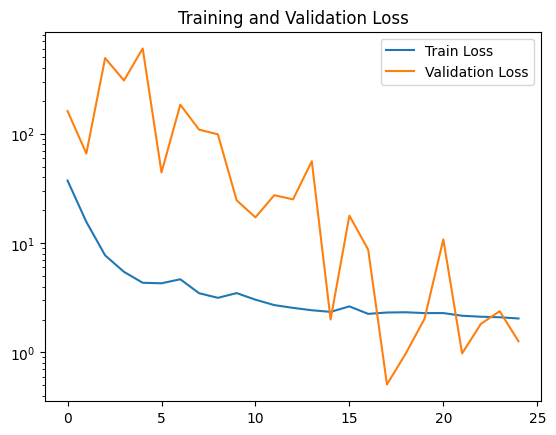

In [ ]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.yscale("log")
plt.show()

 ## Predictions and Plotting

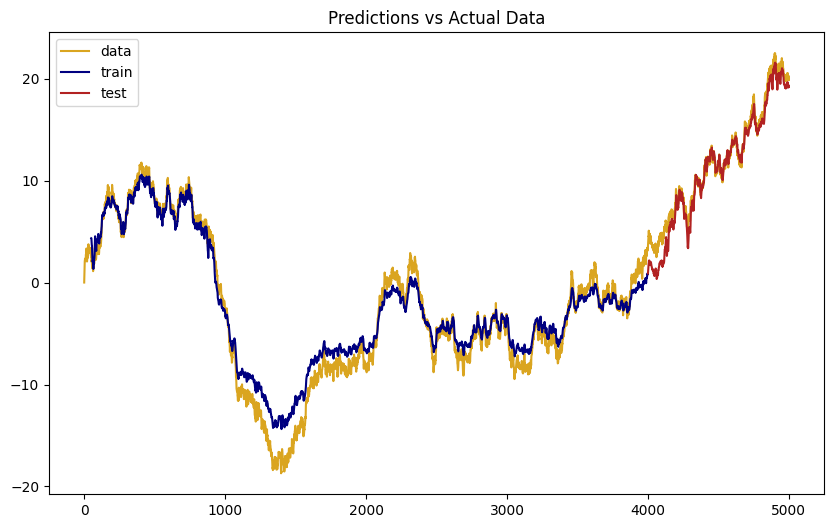

In [20]:
model.eval()
with torch.no_grad():
    train_preds = model(x_train_tensor.to(device)).cpu().numpy()
    test_preds = model(x_test_tensor.to(device)).cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot(data["x"], data["z"], c="goldenrod", label="data")
plt.plot(data.iloc[length : -len(y_test)]["x"], train_preds, c="navy", label="train")
plt.plot(data.iloc[-len(y_test) :]["x"], test_preds, c="firebrick", label="test")
plt.legend()
plt.title("Predictions vs Actual Data")
plt.show()